# Test Dataset

1. Basecall and align using Dorado and minimap2:

    ```bash
    ~/dorado-0.7.3-linux-x64/bin/dorado basecaller hac,5mCG_5hmCG uf1848/20240905_1712_P2S-02395-A_PAW87958_2d796b97/pod5/ --reference ref/hg38.fna
    --trim adapters > uf1848/uf1848_hac5_unsorted.bam
    ```

2. Sort and index bam:

    ```bash
    samtools sort --write-index -o uf1857_hac430.bam -O BAM --reference ref/hg38.fna uf1857/uf1857_hac430_unsorted.bam
    ```

3. Create a BedMethyl file with Modkit
    
    ```bash
    modkit pileup bam/uf1829.bam bed/uf1829.bed -t 32 --combine-strands --cpg --ignore h --ref ref/hg38.fna --no-filtering
    ```

## Where the data at?

In [1]:
import pandas as pd
import numpy as np

mount = '/mnt/e/ALMA/'
output_path = mount + 'Intermediate_Files/'
zhou2016_probes_path = mount + 'UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv'

## Create PaCMAP reference file

Specifically, create a BED6 file to harmonize CpG probes from EPIC array with their matching genomic locations nanopore sequencing.

In [2]:
# # read df_discovery and df_validation
# df_discovery = pd.read_pickle(
#     output_path+'3314samples_331556cpgs_withbatchcorrection_bvalues.pkl').sort_index().iloc[:,1:]

# # Load the list of suboptimal probes
# array_reference = pd.read_csv(zhou2016_probes_path, sep='\t',index_col=0)

# pacmap_reference = array_reference.loc[df_discovery.columns].reset_index()

# # change values in `orientation` column to match the orientation of the probes in the discovery dataset
# pacmap_reference['orientation'] = pacmap_reference['orientation'].map({'down': '-', 'up': '+'})
# pacmap_reference['score'] = 0

# # Rename `IlmnID` to `name` to follow BED standard
# pacmap_reference = pacmap_reference.rename(columns={'IlmnID': 'name', 'orientation': 'strand'})

# # Order columns
# pacmap_reference = pacmap_reference[['chrm', 'start', 'end', 'name', 'score', 'strand', ]]

# # Sort by `chrm` and `start`
# pacmap_reference = pacmap_reference.sort_values(by=['chrm', 'start'])

# pacmap_reference.to_csv('../data/pacmap_reference.bed', sep='\t', index=False, header=False)

pacmap_reference = pd.read_csv('../data/pacmap_reference.bed', sep='\t',  names=['chrm', 'start', 'end', 'name', 'score', 'strand'])
pacmap_reference

,chrm,start,end,name,score,strand
0,chr1,69590,69592,cg21870274,0,+
1,chr1,864702,864704,cg08258224,0,-
2,chr1,870160,870162,cg16619049,0,-
3,chr1,877158,877160,cg18147296,0,-
4,chr1,898802,898804,cg13938959,0,+
...,...,...,...,...,...,...
331551,chr9,138119084,138119086,cg00378292,0,+
331552,chr9,138120221,138120223,cg07982825,0,-
331553,chr9,138122338,138122340,cg14491707,0,+
331554,chr9,138122548,138122550,cg13811936,0,-


## Combine samples into one dataset

In [3]:
import sys
sys.path.append('../')
# from utils.bed_to_pickle import bed_to_pickle

# df = bed_to_pickle()

# Read bed_to_pickle.py output
df = pd.read_pickle('/mnt/e/nanopore_processed/bed/17samples_331556cpgs_nanopore_bvalues.pkl').sort_index(axis=1).T.astype('float32')
df

,uf1829_BM,uf1829_PB,uf1831_BM,uf1831_PB,uf1833_BM,uf1837_BM,uf1837_PB,uf1839_PB,uf1840_PB,uf1841_BM,uf1842_BM,uf1842_PB,uf1848_BM,uf1851_PB,uf1852_PB,uf1856_BM,uf1856_PB
name,,,,,,,,,,,,,,,,,
cg00000109,0.889,0.968,1.000,1.000,0.800,1.000,1.000,1.000,1.000,0.700,0.885,1.000,0.923,1.000,1.000,0.933,0.917
cg00000236,0.696,0.560,0.833,1.000,1.000,0.889,0.875,1.000,0.889,0.900,0.917,0.833,0.500,0.909,0.913,0.750,0.880
cg00000292,0.750,0.630,0.786,0.833,0.750,0.882,1.000,0.867,1.000,0.667,0.750,0.778,1.000,0.875,0.615,0.875,1.000
cg00000363,0.000,0.286,0.333,0.000,0.250,0.538,0.714,0.385,0.235,0.000,0.053,0.071,0.182,0.286,0.167,0.333,0.211
cg00000622,0.000,0.042,0.000,0.000,0.000,0.000,0.000,0.056,0.067,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg27665860,0.800,0.895,1.000,1.000,0.875,1.000,1.000,0.714,1.000,1.000,0.941,1.000,1.000,0.833,0.938,1.000,1.000
cg27665925,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.059,0.000,0.000,0.000,0.111,0.000,0.000,0.000,0.000
cg27665985,0.200,0.368,0.231,0.400,0.154,0.625,0.625,0.846,0.250,0.133,0.143,0.389,0.100,0.250,0.500,0.083,0.710


### Evaluate missing values

<Axes: >

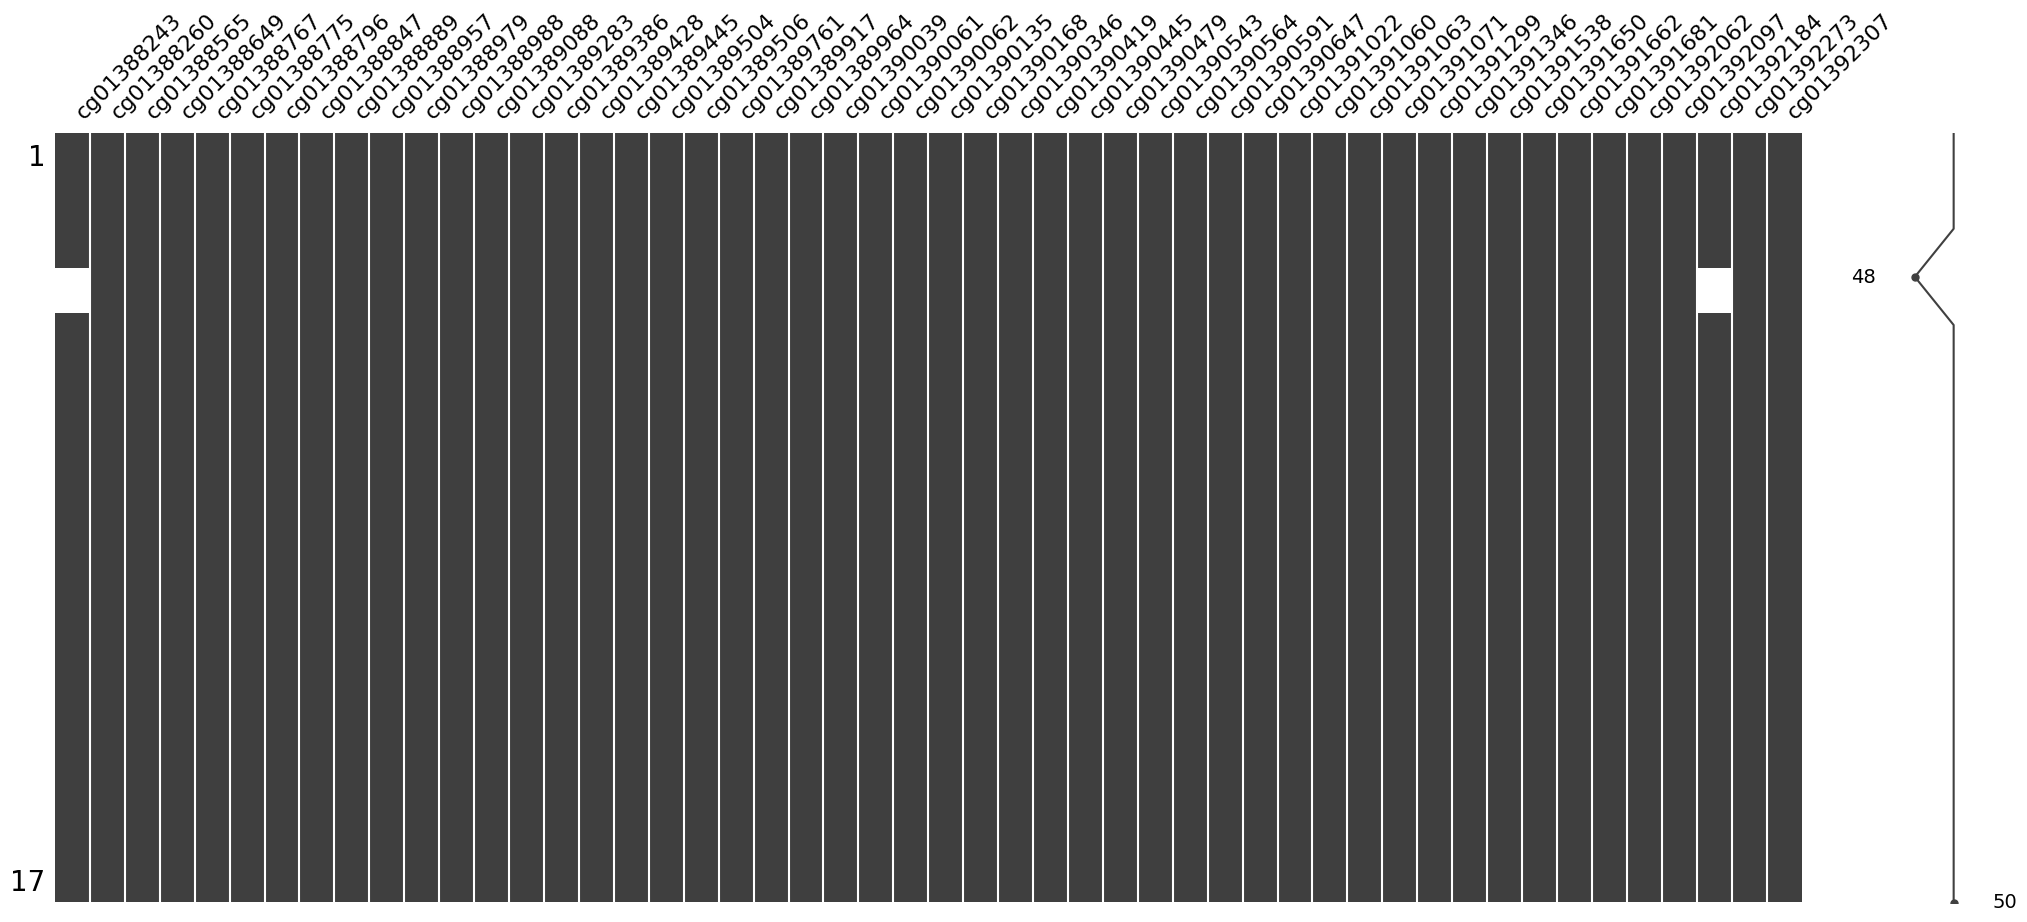

In [4]:
import missingno as msno

# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Impute remaining missing values

<Axes: >

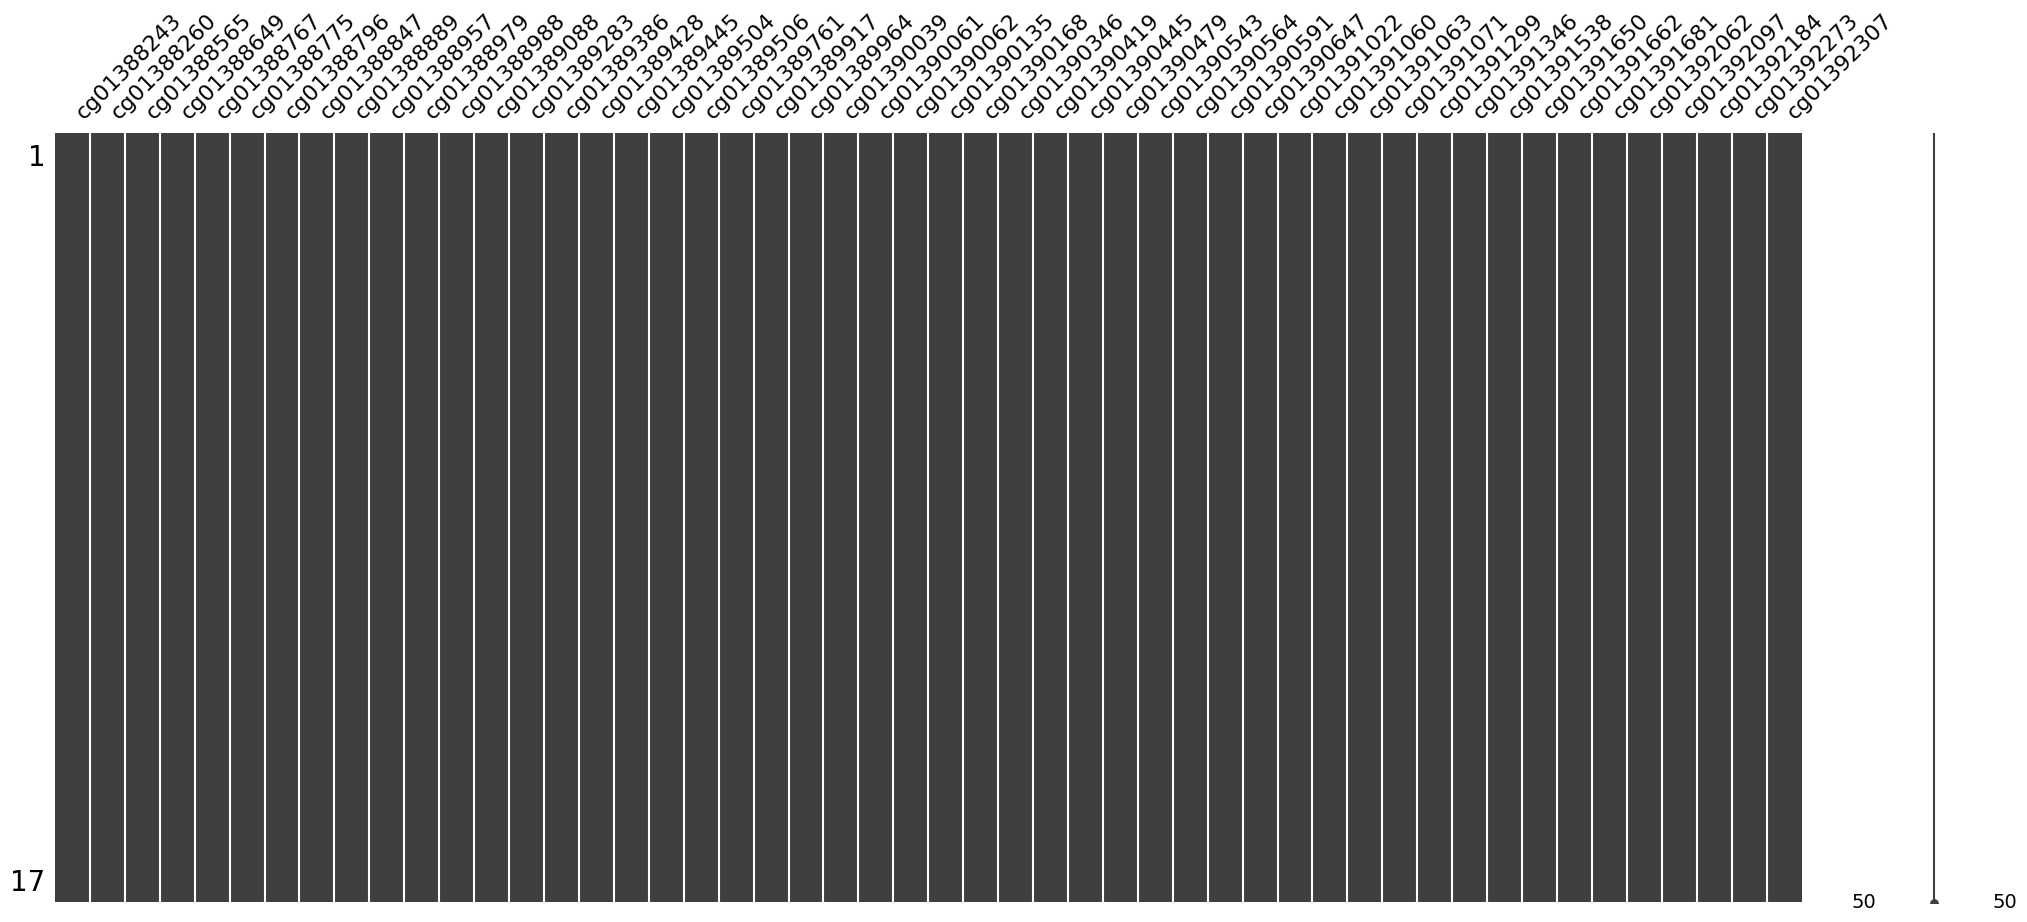

In [5]:
from utils.impute import load_model_and_impute_by_median

df2 = load_model_and_impute_by_median(df, model_path='../models/imputer_model.joblib')

# Plot the missing values
msno.matrix(df2.iloc[20000:20050,:].T.reset_index(drop=True))


## Save batch-corrected beta-values dataset

In [6]:
df2 = df2.T

dataset_title = f'{df2.shape[0]}samples_{df2.shape[1]}cpgs_nanoporeseq_bvalues.pkl'

df2.to_pickle(output_path + dataset_title)

print(f'Successfuly saved at: {output_path + dataset_title}')

Successfuly saved at: /mnt/e/ALMA/Intermediate_Files/17samples_331556cpgs_nanoporeseq_bvalues.pkl


## Watermark

In [7]:
%load_ext watermark

In [8]:
%watermark -v -p pandas -a Francisco_Marchi@Lamba_Lab_UF -d -m -r -u

Author: Francisco_Marchi@Lamba_Lab_UF

Last updated: 2024-09-13

Python implementation: CPython
Python version       : 3.8.18
IPython version      : 8.12.3

pandas: 2.0.3

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Git repo: git@github.com:f-marchi/ALMA.git

